In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from vgg16 import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def _image_parser (path, label):
    
    # Read Image
    image_file = tf.read_file(path)
    image_decoded = tf.image.decode_jpeg(image_file, channels=3)
    image_resized = tf.image.resize_images(image_decoded, INPUT_IMAGE_SIZE)

    return image_resized, label

In [3]:
# Misc
LOG_DIR = './log/'
MODEL_ID = 0.001
IMGNET_PRE_MODEL = './imagenet_pretrained_20/model.ckpt'

# Training Parameters
SHUFFLE_BUFFER= 250
LEARNING_RATE = 0.001
MOMENTUM = 0.9
NUM_EPOCHS = 1
NUM_STEPS = 5000
VAL_STEPS = 100
BATCH_SIZE = 256
DISPLAY_STEP = 1
INPUT_IMAGE_SIZE = [256, 256]
NUM_CLASSES = 20
KEEP_RATE = 0.75

In [4]:
# Data preparation
test = pd.read_csv('../test20.txt', delimiter=' ', header=None).sample(frac=1)

In [5]:
model_graph = tf.Graph()
with model_graph.as_default():
    
    keep_prob = tf.placeholder(tf.float32)
    rand_crop = tf.placeholder(tf.bool)
    
    # Dataset
    test_ds = tf.data.Dataset.from_tensor_slices(
        (np.array(test[0]), np.array(test[1]))).map(_image_parser).batch(BATCH_SIZE)
    
    # Dataset Iterator
    iterator = test_ds.make_one_shot_iterator()
    x, y = iterator.get_next()
    
    # Image Summary
    # tf.summary.image('input', x, 5)
    
    # Build Model
    vgg = MY_VGG16(x=x, keep_rate=keep_prob, num_classes=NUM_CLASSES, 
                   batch_size=BATCH_SIZE, 
                   skip_layers=['fc7', 'fc8'], weights_path='../vgg16.npy',
                   retrain=True, random_crop=rand_crop)
    vgg.build()
    
    # Image Summary
    # tf.summary.image('input', vgg.final_input, 5)
    
    # Logits and Predictions
    logits = vgg.logits
    
    with tf.variable_scope('predictions'):
        pred_classes  = tf.argmax(logits, axis=1, name='prediction_label')
        softmax = tf.nn.softmax(logits, name='softmax')
        tf.summary.histogram('prediction_label', pred_classes)
        tf.summary.histogram('softmax', softmax)

    # Loss
    with tf.variable_scope('cross_entropy_loss'):   
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name='sparse_cross_entropy')
        loss_op = tf.reduce_mean(cross_entropy, name='mean_loss')
        tf.summary.scalar('cross_entropy_loss', loss_op)
    
    # Evaluation
    with tf.variable_scope('accuracy'):
#         true_labels = tf.argmax(y, 1, name='true_label')
        correct_pred = tf.equal(pred_classes, y, name='true_pred_equal')
        accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='mean_accuracy')
        tf.summary.scalar('accuracy', accuracy_op)
    
    # Global Initializer
    global_init = tf.global_variables_initializer()
    
    # Merge Summary
    summary = tf.summary.merge_all()
    
    # Global saver
    saver = tf.train.Saver()

In [ ]:
with tf.Session(graph=model_graph) as sess:
    
    # Debugger
#     sess = tf_debug.TensorBoardDebugWrapperSession(sess, "marr:7000")
    
    # Restore model
    print('Loading model')
    saver.restore(sess, './log/model_0.001/epoch.model.ckpt-3')
    #saver.restore(sess, './imagenet_pretrained_20/model.ckpt')
    print('Model restored.')
    
    print('Start testing.')

    # Testing
    test_acc = 0
    test_loss = 0
    testing_iter = 0

    while True:        
        try:
            loss_val, acc = sess.run([loss_op, accuracy_op], feed_dict={keep_prob: 1.0, rand_crop: False})
            test_acc += acc
            test_loss += loss_val
            testing_iter += 1
            
            print("Testing step" + str(testing_iter) + ", Minibatch Loss= " + \
                "{:.4f}".format(loss_val) + ", Minibatch Accuracy= " + \
                "{:.3f}".format(acc))
            
        except tf.errors.OutOfRangeError:
            break

    assert testing_iter != 0
    print("Overall Testing" + ", Loss= " + \
          "{:.4f}".format(test_loss/testing_iter) + ", Accuracy= " + \
          "{:.3f}".format(test_acc/testing_iter))
    
    print('Done.')

Loading model
INFO:tensorflow:Restoring parameters from ./log/model_0.001/epoch.model.ckpt-3
Model restored.
Start testing.
Testing step1, Minibatch Loss= 0.8508, Minibatch Accuracy= 0.773
Testing step2, Minibatch Loss= 0.6386, Minibatch Accuracy= 0.840
Testing step3, Minibatch Loss= 0.4904, Minibatch Accuracy= 0.887
Testing step4, Minibatch Loss= 0.4952, Minibatch Accuracy= 0.871
Testing step5, Minibatch Loss= 0.5894, Minibatch Accuracy= 0.867
Testing step6, Minibatch Loss= 0.8530, Minibatch Accuracy= 0.805
Testing step7, Minibatch Loss= 0.7115, Minibatch Accuracy= 0.848
Testing step8, Minibatch Loss= 0.7763, Minibatch Accuracy= 0.836
Testing step9, Minibatch Loss= 0.5821, Minibatch Accuracy= 0.848
Testing step10, Minibatch Loss= 0.5333, Minibatch Accuracy= 0.844
Testing step11, Minibatch Loss= 0.9248, Minibatch Accuracy= 0.812
Testing step12, Minibatch Loss= 0.5427, Minibatch Accuracy= 0.852
Testing step13, Minibatch Loss= 0.7243, Minibatch Accuracy= 0.820
Testing step14, Minibatch L

In [115]:
from skimage import io
from skimage.transform import resize

In [5]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient('GuidedRelu')
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]),
                    tf.zeros_like(grad))

In [102]:
def _image_parser (path, label):
    
    # Read Image
    image_file = tf.read_file(path)
    image_decoded = tf.image.decode_jpeg(image_file, channels=3)
    image_resized = tf.image.resize_images(image_decoded, [224, 224])

    return image_resized, label

In [159]:
test.head(1)

,0,1
19280,/home/public/dataset/ecology/Mozambique/Wartho...,19


In [173]:
GRAD_CAM_BATCH_SIZE = 1
test_image = test.loc[5400][0]
true_label = test.loc[5400][1]

In [174]:
grad_cam_graph = tf.Graph()
with grad_cam_graph.as_default():
    with grad_cam_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        
        # Dataset
        test_ds = tf.data.Dataset.from_tensor_slices(
            (np.array([test_image]), np.array([true_label]))).map(_image_parser).repeat().batch(GRAD_CAM_BATCH_SIZE)

        # Dataset Iterator
        iterator = test_ds.make_one_shot_iterator()
        x, y = iterator.get_next()
        
        # Build Model
        vgg = MY_VGG16(x=x, keep_rate=1.0, num_classes=NUM_CLASSES, 
                       batch_size=GRAD_CAM_BATCH_SIZE, 
                       skip_layers=[],
                       retrain=True, random_crop=tf.constant(False))
        vgg.build()
        
        # Image Summary
        image_sum = tf.summary.image('input', vgg.crop_resize, 1)
        
        image = vgg.crop_resize
        
        logits = vgg.logits
        prob = tf.nn.softmax(logits, name='softmax_probabilities')
        
        # The ith logits with the highest probabilities 
        pred_classes  = tf.argmax(logits, axis=1, name='prediction_label')
        pred_one_hot = tf.one_hot(pred_classes, NUM_CLASSES, name='prediction_one_hot')
        ith_logits = tf.reduce_sum(tf.multiply(pred_one_hot, logits), axis=1, name='ith_logits')
        
        # Gradient of the last conv layer
        target_conv_layer = vgg.conv5_3
        target_conv_layer_grad = tf.gradients(ys=ith_logits, xs=target_conv_layer, name='target_conv_layer_gradient')[0]
        
        # Guided backproagation back to input layer
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name='sparse_cross_entropy')
        gb_grad = tf.gradients(cross_entropy, x)
        
        # Global saver
        saver = tf.train.Saver()

In [175]:
with tf.Session(graph=grad_cam_graph) as sess:
    
    # Restore model
    print('Loading model')
    saver.restore(sess, './log/model_0.001/epoch.model.ckpt-0')
    print('Model restored.')
    
    summary= sess.run(image_sum)
    # Write summary
    writer = tf.summary.FileWriter('./temp')
    writer.add_summary(summary)
    writer.close()


    gb_grad_value, \
    target_conv_layer_value, \
    target_conv_layer_grad_value = sess.run([gb_grad, 
                                             target_conv_layer, 
                                             target_conv_layer_grad])

    img = sess.run(tf.cast(vgg.crop_resize, tf.uint8))

Loading model
INFO:tensorflow:Restoring parameters from ./log/model_0.001/epoch.model.ckpt-0
Model restored.


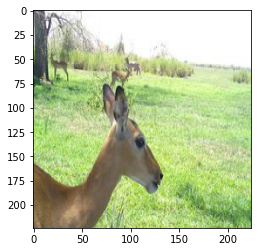

In [176]:
plt.imshow(img[0])

In [177]:
output = target_conv_layer_value[0]
grads_val = target_conv_layer_grad_value[0]

In [178]:
weights = np.mean(grads_val, axis = (0, 1)) # alpha_k, [512]
cam = np.zeros(output.shape[0 : 2], dtype = np.float32) # [7,7]

In [179]:
# Taking a weighted average
for i, w in enumerate(weights):
    cam += w * output[:, :, i]

In [180]:
# Passing through ReLU
cam = np.maximum(cam, 0)
cam = cam / np.max(cam) # scale 0 to 1.0
cam = resize(cam, (224,224), preserve_range=True)

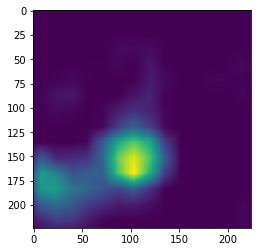

In [181]:
plt.imshow(cam)

In [ ]:
utils.visualize(batch_img[i], target_conv_layer_value[i], target_conv_layer_grad_value[i], gradRGB)a

In [73]:
from PIL import Image

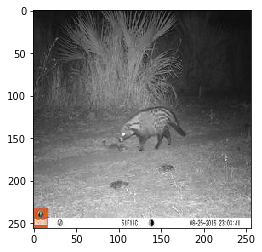

In [91]:
im = Image.open(test.loc[100][0])

plt.imshow(im)